In [ ]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ipywidgets import interactive, HBox, FloatSlider, IntSlider, Text
import warnings
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# This is a Jupyter/IPython magic command to change the current working directory.
# This is specific to your local setup to ensure the relative paths below work correctly.
%cd /Users/adamsobieszek/PycharmProjects/psychGAN/

# --- CONFIGURATION ---
CONFIG = {
    "data": {
        "means_path": "content/omi/attribute_means.csv",
        "ratings_path": "content/omi/attribute_ratings.csv",
        "dlatents_path": "content/coords_wlosses.csv",
        "attribute_dim": "trustworthy", # Default attribute
        "rating_scale_factor": 10.0,
        "max_ratings_per_stimulus_factor": 1.0
    }
}

# --- HELPER FUNCTION ---
def orthogonalize(vector_to_ortho, basis_vector):
    """
    Orthogonalizes a vector with respect to a basis vector using Gram-Schmidt.
    Ensures the basis vector is normalized for correct projection.
    """
    basis_unit = basis_vector / (np.linalg.norm(basis_vector) + 1e-9)
    projection = np.dot(vector_to_ortho, basis_unit) * basis_unit
    orthogonal_component = vector_to_ortho - projection
    return orthogonal_component

# --- DATA PREPARATION FUNCTION ---
def prepare_data(config: dict):
    """
    Loads, filters, and prepares data from CSV files.
    Returns feature (X) and target (y) numpy arrays.
    """
    try:
        means_df = pd.read_csv(config['data']['means_path'])
        ratings_df = pd.read_csv(config['data']['ratings_path'])
        all_dlatents_df = pd.read_csv(config['data']['dlatents_path'])
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure the CSV files are in the correct path.")
        return None, None

    if isinstance(all_dlatents_df["dlatents"].iloc[0], str):
        all_dlatents_df["dlatents"] = all_dlatents_df["dlatents"].apply(eval)

    dim = config['data']['attribute_dim']
    if dim not in ratings_df.attribute.unique():
        print(f"Attribute '{dim}' not found. Available: {list(ratings_df.attribute.unique())}")
        return None, None

    ratings_df = ratings_df.loc[ratings_df.stimulus <= 1004]
    ratings_df = ratings_df.loc[ratings_df.attribute == dim]
    selected_stimuli = means_df.loc[means_df[dim] > 0, 'stimulus']
    ratings_df = ratings_df[ratings_df['stimulus'].isin(selected_stimuli)]
    all_dlatents_df = all_dlatents_df[all_dlatents_df['stimulus'].isin(selected_stimuli)]

    mean_ratings = ratings_df.groupby('stimulus')['rating'].mean()
    sorted_stimuli = mean_ratings.index
    X_df = all_dlatents_df.set_index('stimulus').loc[sorted_stimuli]

    y = mean_ratings.loc[X_df.index].values
    X = np.stack(X_df['dlatents'].values)

    return X.astype(np.float32), y.astype(np.float32)

# --- CORE SIMULATION & PLOTTING CLASS ---
class GradientAlignmentSimulator:
    def __init__(self, full_X, full_y, n_samples, lasso_alpha, cov_matrix, principal_data_axis, true_gradient):
        # --- Store full dataset and pre-computed properties ---
        self.full_X = full_X
        self.full_y_original_noise = full_y # Original ratings used as noise
        self.n_samples = min(n_samples, len(full_X))
        self.cov_matrix = cov_matrix
        self.principal_data_axis = principal_data_axis # PC1
        self.true_gradient = true_gradient # Synthetic gradient

        # --- Create orthogonal basis for plotting ---
        self.orthogonal_gradient_component = orthogonalize(self.true_gradient, self.principal_data_axis)

        # --- Create a working subset of the data ---
        self.X = self.full_X[:self.n_samples]
        # y_noise_subset = self.full_y_original_noise[:self.n_samples]

        # --- Create synthetic 'y' based on the true_gradient, with real ratings as noise ---
        normalize = lambda x: (x - np.mean(x)) / (np.std(x) + 1e-9)
        # true_y_signal = self.X @ self.true_gradient
        # self.y = normalize(true_y_signal) + np.random.randn(self.n_samples) * 0.3
        self.y = full_y


        # --- Fit models on the current synthetic data subset ---
        self._fit_models(lasso_alpha)

    def _fit_models(self, lasso_alpha):
        if self.X.shape[0] <= self.X.shape[1]:
            print("Warning: More features than samples. Results are unstable.")
            self.lr_gradient, self.lasso_gradient, self.ci_from_model = [np.zeros_like(self.true_gradient)] * 3
            return

        self.lr_model = LinearRegression().fit(self.X, self.y)
        self.lr_gradient = self.lr_model.coef_

        # scaler = StandardScaler().fit(self.X)
        # X_scaled = scaler.transform(self.X)
        self.lasso_model = Lasso(alpha=lasso_alpha*10).fit(self.X, self.y)
        self.lasso_gradient = self.lasso_model.coef_ / (np.linalg.norm(self.lasso_model.coef_)+1e-19)

        self.ci_from_model = np.cov(self.X, rowvar=False) @ self.lr_gradient

    def get_converging_gradients(self, num_steps=10):
        """Fits LR models on increasing subsets of data to show convergence."""
        gradients = []
        min_samples = max(self.full_X.shape[1] + 1, int(0.2 * self.n_samples))
        if self.n_samples <= min_samples: return []

        sample_sizes = np.unique(np.linspace(min_samples, self.n_sampleas, num_steps).astype(int))
        normalize = lambda x: (x - np.mean(x)) / (np.std(x) + 1e-9)

        for size in sample_sizes:
            X_subset = self.full_X[:size]
            y_noise_subset = self.full_y_original_noise[:size]
            
            # **FIXED**: Use the same synthetic y generation for converging models
            true_y_signal = X_subset @ self.true_gradient
            y_subset_synthetic = normalize(true_y_signal) + normalize(y_noise_subset) / 5 + np.random.randn(size) * 0.01

            model = LinearRegression().fit(X_subset, y_subset_synthetic)
            gradients.append(model.coef_)
        return gradients

    def project_onto_custom_basis(self, data_to_project):
        """Projects data onto the basis [PC1, Orthogonal_Gradient]."""
        v1 = self.principal_data_axis
        v2 = self.orthogonal_gradient_component
        
        # Ensure basis vectors are normalized
        v1_norm = v1 / (np.linalg.norm(v1) + 1e-9)
        v2_norm = v2 / (np.linalg.norm(v2) + 1e-9)
        
        # **FIXED**: Correctly stack for matrix multiplication
        transform_matrix = np.vstack([v1_norm, v2_norm])
        
        is_1d = data_to_project.ndim == 1
        if is_1d: data_to_project = data_to_project.reshape(1, -1)
            
        # **FIXED**: Correct projection math (data @ basis.T)
        projected = data_to_project @ transform_matrix.T
        return projected[0] if is_1d else projected

    def plot_all(self):
        X_2d = self.project_onto_custom_basis(self.X)

        fig, axes = plt.subplots(1, 3, figsize=(24, 7), dpi=100, gridspec_kw={'width_ratios': [1, 1, 1.2]})
        plt.style.use('seaborn-v0_8-whitegrid')

        # --- Plot 1: Gradient Alignment & Sample Size Effect ---
        ax1 = axes[0]
        ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=self.y, cmap='viridis', alpha=0.7, s=25)
        
        def project_and_plot_arrow(vector, color, label, style='-', zorder=5, lw=2.5, ax=ax1):
            vec_2d = self.project_onto_custom_basis(vector)
            norm = np.linalg.norm(vec_2d)
            if norm == 0: return
            
            xlim_range = np.abs(ax1.get_xlim()[1] - ax1.get_xlim()[0])
            scale_factor = (xlim_range * 0.4) if ax is ax1 else 1.0
            vec_2d_scaled = vec_2d / norm * scale_factor
            
            ax.arrow(0, 0, vec_2d_scaled[0], vec_2d_scaled[1], head_width=0.05 * scale_factor,
                     head_length=0.08 * scale_factor, fc=color, ec=color,
                     linestyle=style, label=label, zorder=zorder, lw=lw)
            dot_product = np.dot(vector/np.linalg.norm(vector), self.ci_from_model/np.linalg.norm(self.ci_from_model))
            

            text_x = vec_2d_scaled[0] * 1.1
            text_y = vec_2d_scaled[1] * 1.1
            ax.text(text_x, text_y, f'{dot_product:.3f}', fontsize=8, color=color, 
                   ha='center', va='center', bbox=dict(boxstyle='round,pad=0.2', 
                   facecolor='white', alpha=0.8, edgecolor=color))


        project_and_plot_arrow(self.principal_data_axis, 'blue', '1st Principal Component')
        project_and_plot_arrow(self.lr_gradient, 'black', f'Linear Regression Gradient (N={self.n_samples})')
        # project_and_plot_arrow(self.true_gradient, 'red', 'True Gradient', style='--')
        project_and_plot_arrow(self.ci_from_model, 'purple', 'Classification Image')
        project_and_plot_arrow(self.lasso_gradient, 'orange', 'Lasso Gradient')

        # converging_grads = self.get_converging_gradients()
        # for i, grad in enumerate(converging_grads):
        #     alpha = 0.3 + 0.7 * (i / len(converging_grads))
        #     project_and_plot_arrow(grad, plt.cm.Greens(alpha), 'Linear Gradients (Increasing N)' if i==0 else "", lw=1.5, zorder=4)

        ax1.set_title('Plot 1: Gradient Alignment vs. Data Covariance', fontsize=14, pad=10)
        ax1.set_xlabel('Projection on 1st Principal Component'); ax1.set_ylabel('Projection on Orthogonal Gradient')
        ax1.legend(loc='best', fontsize='small'); ax1.axis('equal')

        # --- Plot 2: Natural Gradient & Lasso Regularization ---
        ax2 = axes[1]
        project_and_plot_arrow(self.lr_gradient, 'black', f'Linear Regression Gradient (N={self.n_samples})', ax=ax2)
        project_and_plot_arrow(self.true_gradient, 'red', 'True Gradient', style='--', ax=ax2)
        project_and_plot_arrow(self.ci_from_model, 'purple', 'Classification Image', ax=ax2)
        project_and_plot_arrow(self.lasso_gradient, 'orange', 'Lasso Gradient', ax=ax2)

        ax2.set_title(f'Plot 2: Whitening & Regularization', fontsize=14, pad=10)
        ax2.legend(loc='best', fontsize='small'); ax2.set_xlim(-1.2, 1.2); ax2.set_ylim(-1.2, 1.2)
        ax2.set_xlabel('Projection on 1st PC'); ax2.set_ylabel('Projection on Orthogonal Gradient')
        ax2.set_aspect('equal', adjustable='box')

        # --- Plot 3: Feature Covariance Matrix ---
        ax3 = axes[2]
        im = ax3.imshow(self.cov_matrix, cmap='viridis', aspect='auto')
        ax3.set_title(f'Feature Covariance Matrix ({self.cov_matrix.shape[0]}x{self.cov_matrix.shape[1]})', fontsize=14, pad=10)
        ax3.set_xlabel('Feature Index'); ax3.set_ylabel('Feature Index')
        plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

        plt.tight_layout(pad=2.0); plt.show()

# --- Global cache for loaded data and computed items to avoid reloading ---
DATA_CACHE = {}

def interactive_plot_wrapper(attribute_dim, n_samples, lasso_alpha):
    if not attribute_dim: 
        print("Please enter an attribute name.")
        return
        
    cache_key = f"{attribute_dim}_base"
    if cache_key not in DATA_CACHE:
        print(f"Loading data for attribute: '{attribute_dim}'...")
        config = CONFIG.copy()
        config['data']['attribute_dim'] = attribute_dim
        X, y = prepare_data(config)
        y = -y
        if X is None: return
            
        cov_matrix = np.cov(X, rowvar=False)
        pca = PCA(n_components=min(100, X.shape[1])).fit(X)
        X_100 = pca.transform(X)
        #mangnify the first two PC
        # X_100[:,0] *= 20
        # X_100[:,1] *= 5
        # # transform back
        true_gradient = LinearRegression().fit(X, y).coef_
        # X = pca.inverse_transform(X_100)+X
        principal_data_axis = pca.components_[0]
        # Create a synthetic "true" gradient from a random combination of the top 100 PCs
        weights = np.random.randn(pca.n_components_)
        # np.sum([pc / (np.linalg.norm(pc)+1e-9) for w, pc in zip(weights, pca.components_)], axis=0)
        
        DATA_CACHE[cache_key] = (X, y, cov_matrix, principal_data_axis, true_gradient)
    
    full_X, full_y, cov_matrix, principal_data_axis, true_gradient = DATA_CACHE[cache_key]
    
    n_samples_slider.max = len(full_X)
    if n_samples > len(full_X): n_samples = len(full_X)

    print(f"Running simulation with N={n_samples} and Lasso Alpha={lasso_alpha:.3f}")
    simulator = GradientAlignmentSimulator(full_X, full_y, n_samples, lasso_alpha, cov_matrix, principal_data_axis, true_gradient)
    simulator.plot_all()

# --- Create Interactive Widgets ---
attribute_input = Text(value='trustworthy', description='Attribute:', layout={'width': '300px'})
n_samples_slider = IntSlider(value=1004, min=1004, max=1004, step=5, description='Num Samples (N):')
lasso_slider = FloatSlider(value=0.1, min=0.001, max=200.1, step=.1, description='Lasso Alpha:', readout_format='.3f')



interactive_output = interactive(interactive_plot_wrapper, attribute_dim=attribute_input, n_samples=n_samples_slider, lasso_alpha=lasso_slider)

# --- Display Widgets and Instructions ---
print("--- Interactive Simulation Controls ---")
print("Enter a valid attribute name and press Enter. Then adjust the sliders.")
display(HBox([attribute_input, n_samples_slider, lasso_slider]))
display(interactive_output.children[-1])
interactive_output.update()



/Users/adamsobieszek/PycharmProjects/psychGAN


--- Interactive Simulation Controls ---
Enter a valid attribute name and press Enter. Then adjust the sliders.


Output()

In [3]:
# --- IMPORTS ---
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ipywidgets import interactive, HBox, IntSlider, Text
import warnings
from IPython.display import display

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# This is a Jupyter/IPython magic command to change the current working directory.
# This is specific to your local setup to ensure the relative paths below work correctly.
%cd /Users/adamsobieszek/PycharmProjects/psychGAN/

# --- CONFIGURATION ---
CONFIG = {
    "data": {
        "means_path": "content/omi/attribute_means.csv",
        "ratings_path": "content/omi/attribute_ratings.csv",
        "dlatents_path": "content/coords_wlosses.csv",
        "attribute_dim": "trustworthy", # Default attribute
        "rating_scale_factor": 10.0,
        "max_ratings_per_stimulus_factor": 1.0
    }
}

# --- HELPER FUNCTION ---
def orthogonalize(vector_to_ortho, basis_vector):
    """
    Orthogonalizes a vector with respect to a basis vector using Gram-Schmidt.
    """
    basis_unit = basis_vector / (np.linalg.norm(basis_vector) + 1e-9)
    projection = np.dot(vector_to_ortho, basis_unit) * basis_unit
    orthogonal_component = vector_to_ortho - projection
    return orthogonal_component

# --- DATA PREPARATION FUNCTION ---
def prepare_data(config: dict):
    """
    Loads, filters, and prepares data from CSV files.
    Returns feature (X) and target (y) numpy arrays.
    """
    try:
        means_df = pd.read_csv(config['data']['means_path'])
        ratings_df = pd.read_csv(config['data']['ratings_path'])
        all_dlatents_df = pd.read_csv(config['data']['dlatents_path'])
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure the CSV files are in the correct path.")
        return None, None

    if isinstance(all_dlatents_df["dlatents"].iloc[0], str):
        all_dlatents_df["dlatents"] = all_dlatents_df["dlatents"].apply(eval)

    dim = config['data']['attribute_dim']
    if dim not in ratings_df.attribute.unique():
        print(f"Attribute '{dim}' not found. Available: {list(ratings_df.attribute.unique())}")
        return None, None

    ratings_df = ratings_df.loc[ratings_df.stimulus <= 1004]
    ratings_df = ratings_df.loc[ratings_df.attribute == dim]
    selected_stimuli = means_df.loc[means_df[dim] > 0, 'stimulus']
    ratings_df = ratings_df[ratings_df['stimulus'].isin(selected_stimuli)]
    all_dlatents_df = all_dlatents_df[all_dlatents_df['stimulus'].isin(selected_stimuli)]

    mean_ratings = ratings_df.groupby('stimulus')['rating'].mean()
    sorted_stimuli = mean_ratings.index
    X_df = all_dlatents_df.set_index('stimulus').loc[sorted_stimuli]

    y = mean_ratings.loc[X_df.index].values
    X = np.stack(X_df['dlatents'].values)

    return X.astype(np.float32), y.astype(np.float32)

# --- CORE SIMULATION & PLOTTING CLASS ---
class GradientAlignmentSimulator:
    def __init__(self, full_X, full_y, n_samples, cov_matrix, principal_data_axis):
        # --- Store full dataset and pre-computed properties ---
        self.full_X = full_X
        self.full_y = full_y
        self.n_samples = min(n_samples, len(full_X))
        self.cov_matrix = cov_matrix
        self.principal_data_axis = principal_data_axis # PC1

        # --- Create a working subset of the data ---
        self.X = self.full_X[:self.n_samples]
        self.y = self.full_y[:self.n_samples]

        # --- Split data into quantiles ---
        self._split_data()

        # --- Fit models on the current data subset ---
        self._fit_models()

        # --- Create orthogonal basis for plotting based on the new gradient ---
        self.orthogonal_gradient_component = orthogonalize(self.logistic_gradient, self.principal_data_axis)

    def _split_data(self):
        """Splits the data into low, neutral, and high quantiles based on y."""
        low_threshold = np.percentile(self.y, 33.3)
        high_threshold = np.percentile(self.y, 66.6)
        
        self.low_mask = self.y < low_threshold
        self.high_mask = self.y > high_threshold
        
        self.X_low = self.X[self.low_mask]
        self.X_high = self.X[self.high_mask]
        
        if len(self.X_low) == 0 or len(self.X_high) == 0:
            print("Warning: Not enough data to form both low and high groups. Using dummy data.")
            self.X_low = self.X[:1] if len(self.X_low) == 0 else self.X_low
            self.X_high = self.X[-1:] if len(self.X_high) == 0 else self.X_high
            

    def _fit_models(self):
        """Fits logistic regression and computes the three key vectors."""
        # --- 1. Logistic Regression Manipulation Vector ---
        X_class = np.vstack([self.X_low, self.X_high])
        y_class = np.array([0] * len(self.X_low) + [1] * len(self.X_high))

        # Use regularization for stability, especially with small N
        logit_model = LogisticRegression(solver='liblinear', C=1000000, random_state=42).fit(X_class, y_class)
        self.logistic_gradient = logit_model.coef_[0]

        # --- 2. Classification Image from Model (cov @ beta) ---
        self.ci_from_model = self.cov_matrix @ self.logistic_gradient

        # --- 3. Classification Image from Means (mean(H) - mean(L)) ---
        self.ci_from_means = np.mean(self.X_high, axis=0) - np.mean(self.X_low, axis=0)

        # --- 4. Natural Gradient (cov^-1 @ ci) ---
        inverse_cov_matrix = np.linalg.inv(self.cov_matrix)
        self.natural_gradient = inverse_cov_matrix @ self.ci_from_means

    def project_onto_custom_basis(self, data_to_project):
        """Projects data onto the basis [PC1, Orthogonal_Gradient]."""
        v1 = self.principal_data_axis
        v2 = self.orthogonal_gradient_component
        
        v1_norm = v1 / (np.linalg.norm(v1) + 1e-9)
        v2_norm = v2 / (np.linalg.norm(v2) + 1e-9)
        
        transform_matrix = np.vstack([v1_norm, v2_norm])
        
        is_1d = data_to_project.ndim == 1
        if is_1d: data_to_project = data_to_project.reshape(1, -1)
            
        projected = data_to_project @ transform_matrix.T
        return projected[0] if is_1d else projected

    def plot_all(self):
        # Project data points for scatter plot
        X_low_2d = self.project_onto_custom_basis(self.X_low)
        X_high_2d = self.project_onto_custom_basis(self.X_high)

        fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=100)
        plt.style.use('seaborn-v0_8-whitegrid')

        # --- Plot 1: Vector Alignment ---
        ax.scatter(X_low_2d[:, 0], X_low_2d[:, 1], c='skyblue', label='Low-Rated Group', alpha=0.7, s=30)
        ax.scatter(X_high_2d[:, 0], X_high_2d[:, 1], c='salmon', label='High-Rated Group', alpha=0.7, s=30)

        def project_and_plot_arrow(vector, color, label, style='-', zorder=5, lw=2.5, ax=ax):
            vec_2d = self.project_onto_custom_basis(vector)
            norm = np.linalg.norm(vec_2d)
            if norm < 1e-9: return
            
            xlim_range = np.abs(ax.get_xlim()[1] - ax.get_xlim()[0])
            scale_factor = (xlim_range * 0.4)
            vec_2d_scaled = vec_2d / norm * scale_factor
            
            ax.arrow(0, 0, vec_2d_scaled[0], vec_2d_scaled[1], head_width=0.03 * scale_factor,
                     head_length=0.05 * scale_factor, fc=color, ec=color,
                     linestyle=style, label=label, zorder=zorder, lw=lw)
            
            # Add text showing dot product with CI from means
            dot_product = np.dot(vector/np.linalg.norm(vector), self.ci_from_means/np.linalg.norm(self.ci_from_means))

            text_x = vec_2d_scaled[0] * 1.1
            text_y = vec_2d_scaled[1] * 1.1
            ax.text(text_x, text_y, f'{dot_product:.3f}', fontsize=8, color=color, 
                   ha='center', va='center', bbox=dict(boxstyle='round,pad=0.2', 
                   facecolor='white', alpha=0.8, edgecolor=color))

        project_and_plot_arrow(self.principal_data_axis, 'gray', '1st Principal Component', lw=1.5, style=':')
        project_and_plot_arrow(self.logistic_gradient, 'red', 'Manipulation Vector (Logistic Regression)', lw=3)
        project_and_plot_arrow(self.ci_from_model, 'purple', 'CI from Model (cov @ beta)', style='--')
        project_and_plot_arrow(self.ci_from_means, 'green', 'CI from Means (mean(H)-mean(L))', style='-.')
        project_and_plot_arrow(self.natural_gradient, 'blue', 'Natural Gradient (cov^-1 @ ci)', style='--')

        ax.set_title(f'Estimator Alignment (N={self.n_samples})', fontsize=16, pad=15)
        ax.set_xlabel('Projection on 1st Principal Component')

        ax.set_ylabel('Projection on Orthogonal Gradient Component')
        ax.legend(loc='best', fontsize='medium')
        ax.axis('equal')
        
        plt.tight_layout(pad=2.0)
        plt.show()

# --- Global cache for loaded data and computed items to avoid reloading ---
DATA_CACHE = {}

def interactive_plot_wrapper(attribute_dim, n_samples):
    if not attribute_dim: 
        print("Please enter an attribute name.")
        return
        
    cache_key = f"{attribute_dim}_base"
    if cache_key not in DATA_CACHE:
        print(f"Loading data for attribute: '{attribute_dim}'...")
        config = CONFIG.copy()
        config['data']['attribute_dim'] = attribute_dim
        X, y = prepare_data(config)
        y = -y # Invert ratings so higher is better
        if X is None: return
            
        # pca = PCA(n_components=100).fit(X)
        # X = pca.transform(X)
        pca = PCA(n_components=1).fit(X)
        principal_data_axis = pca.components_[0]
        cov_matrix = np.cov(X, rowvar=False)

        
        DATA_CACHE[cache_key] = (X, y, cov_matrix, principal_data_axis)
    
    full_X, full_y, cov_matrix, principal_data_axis = DATA_CACHE[cache_key]
    
    n_samples_slider.max = len(full_X)
    if n_samples > len(full_X): n_samples = len(full_X)

    print(f"Running simulation with N={n_samples}")
    simulator = GradientAlignmentSimulator(full_X, full_y, n_samples, cov_matrix, principal_data_axis)
    simulator.plot_all()

# --- Create Interactive Widgets ---
attribute_input = Text(value='trustworthy', description='Attribute:', layout={'width': '300px'})
n_samples_slider = IntSlider(value=1004, min=200, max=1004, step=10, description='Num Samples (N):')

interactive_output = interactive(interactive_plot_wrapper, attribute_dim=attribute_input, n_samples=n_samples_slider)

# --- Display Widgets and Instructions ---
print("--- Interactive Simulation Controls ---")
print("Enter a valid attribute name and press Enter. Then adjust the slider.")
display(HBox([attribute_input, n_samples_slider]))
display(interactive_output.children[-1])
interactive_output.update()



/Users/adamsobieszek/PycharmProjects/psychGAN


--- Interactive Simulation Controls ---
Enter a valid attribute name and press Enter. Then adjust the slider.


Output()

Created 204845 paired differences for analysis.

--- Goodness of Fit Test Results ---
Lower K-S statistic indicates a better fit.

Gaussian Fit K-S Statistic: 0.0351 (p-value: 0.0000)
Logistic Fit K-S Statistic: 0.0150 (p-value: 0.0000)

Conclusion: The Logistic distribution appears to be a better fit for the rating differences.

--- Generating Visualizations ---


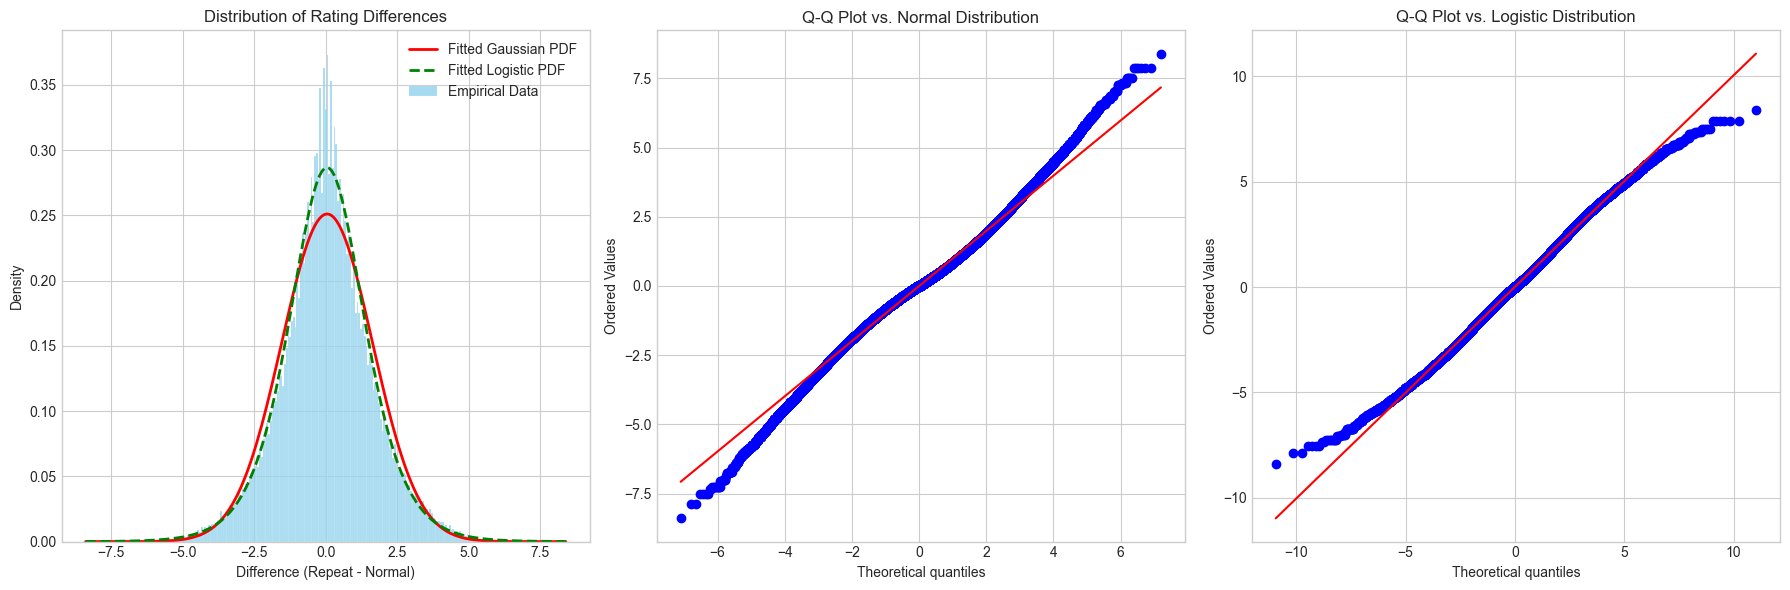

In [4]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# --- 1. Load and Prepare Data ---
# The dataframe is assumed to be loaded in the notebook environment as `ratings_df`
# For example:
ratings_df = pd.read_csv(CONFIG['data']['ratings_path'])


# --- 2. Create Paired Differences ---

all_differences = []
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.min(),:]
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.max(),:]
ratings_df['rating'] = (ratings_df['rating']+0.5)/101
ratings_df['rating'] = np.log(ratings_df['rating']/(1-ratings_df['rating']))

# Group data by stimulus and attribute to create pairs within each context
grouped = ratings_df.groupby(['stimulus', 'attribute'])

for _, group_df in grouped:
    repeat_ratings = group_df[group_df['rating_type'] == 'repeat']['rating'].values
    normal_ratings = group_df[group_df['rating_type'] == 'normal']['rating'].values
    
    # Determine the number of pairs to create (the size of the smaller group)
    num_pairs = min(len(repeat_ratings), len(normal_ratings))
    
    if num_pairs > 0:
        # Shuffle both arrays to ensure random pairing
        np.random.shuffle(repeat_ratings)
        np.random.shuffle(normal_ratings)
        
        # Calculate differences for the paired ratings
        differences = repeat_ratings[:num_pairs] - normal_ratings[:num_pairs]
        all_differences.extend(differences)

# Convert to a NumPy array for statistical analysis
all_differences = np.asarray(all_differences)

print(f"Created {len(all_differences)} paired differences for analysis.\n")


# --- 3. Fit Distributions and Perform Statistical Tests ---

# Fit a Normal (Gaussian) distribution to the differences
norm_loc, norm_scale = stats.norm.fit(all_differences)
ks_stat_norm, p_value_norm = stats.kstest(all_differences, 'norm', args=(norm_loc, norm_scale))

# Fit a Logistic distribution to the differences
log_loc, log_scale = stats.logistic.fit(all_differences)
ks_stat_log, p_value_log = stats.kstest(all_differences, 'logistic', args=(log_loc, log_scale))


# --- 4. Report Statistical Results ---

print("--- Goodness of Fit Test Results ---")
print(f"Lower K-S statistic indicates a better fit.\n")
print(f"Gaussian Fit K-S Statistic: {ks_stat_norm:.4f} (p-value: {p_value_norm:.4f})")
print(f"Logistic Fit K-S Statistic: {ks_stat_log:.4f} (p-value: {p_value_log:.4f})\n")

if ks_stat_norm < ks_stat_log:
    print("Conclusion: The Gaussian (Normal) distribution appears to be a better fit for the rating differences.")
else:
    print("Conclusion: The Logistic distribution appears to be a better fit for the rating differences.")


# --- 5. Generate Visualizations ---

print("\n--- Generating Visualizations ---")
sns.set_style("whitegrid")
plt.figure(figsize=(18, 6))

# Plot 1: Histogram with overlaid PDF curves
plt.subplot(1, 3, 1)
sns.histplot(all_differences, kde=False, stat='density', label='Empirical Data', color='skyblue')
x_range = np.linspace(min(all_differences), max(all_differences), 200)
plt.plot(x_range, stats.norm.pdf(x_range, norm_loc, norm_scale), 'r-', lw=2, label='Fitted Gaussian PDF')
plt.plot(x_range, stats.logistic.pdf(x_range, log_loc, log_scale), 'g--', lw=2, label='Fitted Logistic PDF')
plt.title('Distribution of Rating Differences')
plt.xlabel('Difference (Repeat - Normal)')
plt.ylabel('Density')
plt.legend()

# Plot 2: Q-Q plot for Normal fit
plt.subplot(1, 3, 2)
stats.probplot(all_differences, dist=stats.norm, sparams=(norm_loc, norm_scale), plot=plt)
plt.title('Q-Q Plot vs. Normal Distribution')

# Plot 3: Q-Q plot for Logistic fit
plt.subplot(1, 3, 3)
stats.probplot(all_differences, dist=stats.logistic, sparams=(log_loc, log_scale), plot=plt)
plt.title('Q-Q Plot vs. Logistic Distribution')

plt.tight_layout()
plt.show()



In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

import sys
sys.path.append('/Users/adamsobieszek/PycharmProjects/manipy/')
from src.beta.mixup.interpolate import fit_beta

# --- 1. Load and Prepare Data ---
# The dataframe is assumed to be loaded in the notebook environment as `ratings_df`
# For example:
ratings_df = pd.read_csv(CONFIG['data']['ratings_path'])


# --- 2. Pre-process and Transform Ratings ---
# Remove ratings at the extreme ends of the scale
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.min(),:]
ratings_df=ratings_df.loc[ratings_df.rating != ratings_df.rating.max(),:]
# Apply logit transformation to map [0, 100] scale to an unbounded space
ratings_df['rating_transformed'] = (ratings_df['rating']+0.5)/101
# ratings_df['rating_transformed'] = np.log(ratings_df['rating_transformed']/(1-ratings_df['rating_transformed']))


# --- 3. Per-Attribute Analysis ---
attribute_results = []
attribute_differences = {}

# Group data by attribute
grouped_by_attr = ratings_df.groupby('attribute')

for attribute, attr_df in grouped_by_attr:
    # Create paired differences for the current attribute
    repeat_ratings = attr_df[attr_df['rating_type'] == 'repeat']['rating_transformed'].values
    normal_ratings = attr_df[attr_df['rating_type'] == 'normal']['rating_transformed'].values
    
    # a_normal,b_normal = fit_beta(torch.sigmoid(torch.tensor(normal_ratings)).numpy())
    # a_repeat,b_repeat = fit_beta(torch.sigmoid(torch.tensor(repeat_ratings)).numpy())
    normal_abs = []
    repeat_abs = []
    for i in attr_df.stimulus.unique():
        normal_abs.append(fit_beta(torch.sigmoid(torch.tensor(attr_df.loc[attr_df['stimulus'] == i, 'rating_transformed'].values)).numpy()))
        repeat_abs.append(fit_beta(torch.sigmoid(torch.tensor(attr_df.loc[attr_df['stimulus'] == i, 'rating_transformed'].values)).numpy()))
    a_normal,b_normal = np.mean(normal_abs, axis=0)
    a_repeat,b_repeat = np.mean(repeat_abs, axis=0)
    
    num_pairs = min(len(repeat_ratings), len(normal_ratings))
    
    if num_pairs < 10: # Skip attributes with too few pairs for a reliable fit
        continue
    diffs = []
    for i in range(200):
        np.random.shuffle(repeat_ratings)
        np.random.shuffle(normal_ratings)
        differences = repeat_ratings[:num_pairs] - normal_ratings[:num_pairs]
        diffs.append(differences)
    differences = np.concatenate(diffs)
    differences = (differences - np.mean(differences))/np.std(differences)
    attribute_differences[attribute] = differences
    
    # Fit distributions and perform K-S tests
    norm_loc, norm_scale = stats.norm.fit(differences)
    ks_stat_norm, p_value_norm = stats.kstest(differences, 'norm', args=(norm_loc, norm_scale))
    
    log_loc, log_scale = stats.logistic.fit(differences)
    ks_stat_log, p_value_log = stats.kstest(differences, 'logistic', args=(log_loc, log_scale))
    
    # Store results
    attribute_results.append({
        'attribute': attribute,
        'ks_stat_norm': ks_stat_norm,
        'ks_stat_logistic': ks_stat_log,
        'fit_ratio': ks_stat_norm / ks_stat_log if ks_stat_log > 0 else np.inf,
        "beta_params": f"ab_normal: ({a_normal:.2f}, {b_normal:.2f}), ab_repeat: ({a_repeat:.2f}, {b_repeat:.2f})"
    })

# --- 4. Rank and Report Results ---



if attribute_results:
    results_df = pd.DataFrame(attribute_results).sort_values('fit_ratio', ascending=False).reset_index(drop=True)
    
    print("--- Analysis of Noise Distribution by Attribute ---")
    print("Attributes ranked by how much better a Logistic fit is compared to a Gaussian fit.")
    print("A 'fit_ratio' > 1.0 indicates Logistic is a better fit (lower K-S statistic).\n")
    
    num_attributes = len(results_df)
    display_n = 10
    
    if num_attributes <= display_n * 2:
        top_and_bottom_df = results_df
    else:
        top_df = results_df.head(display_n)
        bottom_df = results_df.tail(display_n)
        top_and_bottom_df = pd.concat([top_df, bottom_df])

    print(top_df.iloc[:,[0,-1,1,2,3]].to_string(index=False))
    print(bottom_df.iloc[::-1,[0,-1,1,2,3]].to_string(index=False))
    
    # --- 5. Generate Visualizations for Top and Bottom Attributes ---
    
    print("\n--- Generating Visualizations for Top and Bottom Attributes ---")
    sns.set_style("whitegrid")
    
    # for _, row in top_and_bottom_df.iterrows():
    #     attribute_to_plot = row['attribute']
    #     differences_to_plot = attribute_differences[attribute_to_plot]
        
    #     # Fit models again for plotting
    #     norm_loc, norm_scale = stats.norm.fit(differences_to_plot)
    #     log_loc, log_scale = stats.logistic.fit(differences_to_plot)
        
    #     fig = plt.figure(figsize=(18, 5))
    #     fig.suptitle(f'Noise Distribution for Attribute: "{attribute_to_plot}" (Fit Ratio: {row.fit_ratio:.2f})', fontsize=16)

    #     # Plot 1: Histogram
    #     plt.subplot(1, 3, 1)
    #     sns.histplot(differences_to_plot, kde=False, stat='density', label='Empirical Data', color='skyblue')
    #     x_range = np.linspace(min(differences_to_plot), max(differences_to_plot), 200)
    #     plt.plot(x_range, stats.norm.pdf(x_range, norm_loc, norm_scale), 'r-', lw=2, label='Fitted Gaussian')
    #     plt.plot(x_range, stats.logistic.pdf(x_range, log_loc, log_scale), 'g--', lw=2.5, label='Fitted Logistic')
    #     plt.title('Distribution of Differences')
    #     plt.xlabel('Difference (Repeat - Normal)')
    #     plt.ylabel('Density')
    #     plt.legend()

    #     # Plot 2: Q-Q plot vs. Normal
    #     plt.subplot(1, 3, 2)
    #     stats.probplot(differences_to_plot, dist=stats.norm, sparams=(norm_loc, norm_scale), plot=plt)
    #     plt.title('Q-Q Plot vs. Normal')

    #     # Plot 3: Q-Q plot vs. Logistic
    #     plt.subplot(1, 3, 3)
    #     stats.probplot(differences_to_plot, dist=stats.logistic, sparams=(log_loc, log_scale), plot=plt)
    #     plt.title('Q-Q Plot vs. Logistic')

    #     plt.tight_layout(rect=[0, 0, 1, 0.95])
    #     plt.show()

else:
    print("No attributes with sufficient data to perform analysis.")



--- Analysis of Noise Distribution by Attribute ---
Attributes ranked by how much better a Logistic fit is compared to a Gaussian fit.
A 'fit_ratio' > 1.0 indicates Logistic is a better fit (lower K-S statistic).

     attribute                                              beta_params  ks_stat_norm  ks_stat_logistic  fit_ratio
    skin-color ab_normal: (175.23, 139.92), ab_repeat: (175.23, 139.92)      0.029147          0.018065   1.613431
         black ab_normal: (375.71, 334.92), ab_repeat: (375.71, 334.92)      0.087226          0.075573   1.154185
         white   ab_normal: (160.17, 89.32), ab_repeat: (160.17, 89.32)      0.024977          0.029562   0.844881
looks-like-you     ab_normal: (52.30, 40.32), ab_repeat: (52.30, 40.32)      0.028315          0.033587   0.843022
      outdoors   ab_normal: (120.88, 69.55), ab_repeat: (120.88, 69.55)      0.033591          0.049306   0.681282
         asian ab_normal: (226.36, 190.74), ab_repeat: (226.36, 190.74)      0.031711          0

In [36]:
%pwd

'/Users/adamsobieszek/PycharmProjects/psychGAN'